### Notebook to evaluate potential response bias effects on the starting point paramater

To assess whether SC biases the response (towards animal or non-animal) reflected in changes in the starting point, we fitted several models:

1. one model in which we estimate only the response bias z for every complexity condition (low, med, high), such that the bias for animal stimuli is z and the bias for non-animal stimuli is 1-z (z = 0.5 for unbiased decisions in HDDM.
2. one model in which we estimate both v and z. This way, we could measure response-bias (in favor of animal or non-animal) and drift rate for the three conditions (low, med, high) while assuming the same drift rate for both stimuli.
3. one model in which we estimate *v*, *z* and *a* for every complexity condition.
4. one model in which we estimate *v*, *z* and *a* for every complexity condition and, using the depends_on key argument, two intercepts for *a* (speed, accurate)
5. same model as 4, now using 'medium' as the intercept for z

    Then, because people often encounter problems (with convergence) when using HDDMRegressor to estimate *z*, we fit 

6. one model using HDDMStimCoding, in which we estimate *v*, *z* for every complexity condition, and *a* for every complexity condition + speed/accuracy instruction

    Finally, we test 

7. our original model, now including 'z' (note however that for the original model the data was accuracy coded, so the boundaries reflect correct vs. incorrect responses) 



First, some imports:

In [25]:
import hddm
from patsy import dmatrix  # for generation of (regression) design matrices
import numpy as np         # for basic matrix operations
from pandas import Series  # to manipulate data-frames generated by hddm
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import os.path 
import hddm
from scipy.stats import pearsonr, percentileofscore, ttest_ind, ttest_rel, wilcoxon, ranksums, mode
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt
from patsy import center
%matplotlib inline 
cmap = sns.color_palette("hls", 8)
sns.set_palette(cmap)
sns.set_style("white")
import kabuki
import ipyparallel as ipp

Import IPython parallel computing clusters, so that we can run multiple chains in parallel:

In [56]:
# test parallel
c = ipp.Client()
c.ids
c[:].apply_sync(lambda : "test")

['test', 'test', 'test', 'test']

** load the data**

In [17]:
#load data
data = hddm.load_csv('/home/Projects/scenestats/exp1_scce.csv') 
data = data.dropna()
data.head(-30)

,Unnamed: 0,lmh,SpAc,stimulus,stimulus_recoded_01,resp,correct,rt,subj_idx,CE,SC,CE_c,SC_c,CE_squared,SC_squared
0,0,low,Sp,2,0,0,1,0.269,ppn10,0.059630,0.648035,-0.380350,-0.276190,0.144666,0.076281
1,1,low,Sp,2,0,1,0,0.783,ppn10,0.156877,0.652993,-0.283103,-0.271231,0.080147,0.073566
2,2,low,Sp,1,1,1,1,0.626,ppn10,0.112617,0.632840,-0.327363,-0.291385,0.107167,0.084905
3,3,low,Sp,2,0,0,1,0.637,ppn10,0.213033,0.725208,-0.226947,-0.199016,0.051505,0.039607
4,4,low,Sp,1,1,1,1,0.366,ppn10,0.267030,0.682406,-0.172950,-0.241819,0.029912,0.058476
5,5,low,Sp,1,1,0,0,0.485,ppn10,0.105226,0.613989,-0.334754,-0.310235,0.112060,0.096246
6,6,low,Sp,1,1,1,1,0.481,ppn10,0.129534,0.706614,-0.310446,-0.217611,0.096377,0.047354
7,7,low,Sp,1,1,1,1,0.480,ppn10,0.138911,0.564420,-0.301069,-0.359804,0.090643,0.129459
8,8,low,Sp,2,0,0,1,0.439,ppn10,0.128778,0.495516,-0.311202,-0.428708,0.096846,0.183791
9,9,low,Sp,1,1,1,1,0.292,ppn10,0.083869,0.482984,-0.356111,-0.441241,0.126815,0.194693


**1. one model in which we estimate only the response bias z for every complexity condition (low, med, high)**
such that the bias for animal stimuli is z and the bias for non-animal stimuli is 1-z (z = 0.5 for unbiased decisions in HDDM.


Plotting a
Plotting a_std
Plotting v
Plotting v_std
Plotting t
Plotting t_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_C(lmh)[T.low]
Plotting z_C(lmh)[T.med]


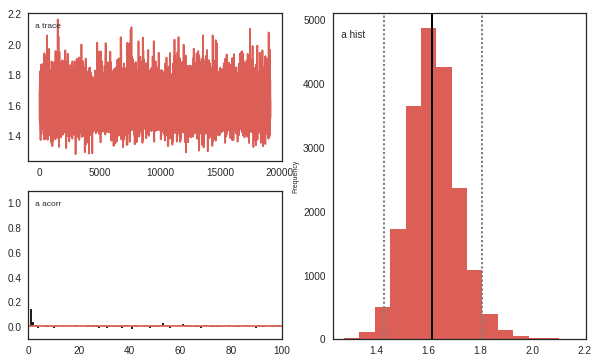

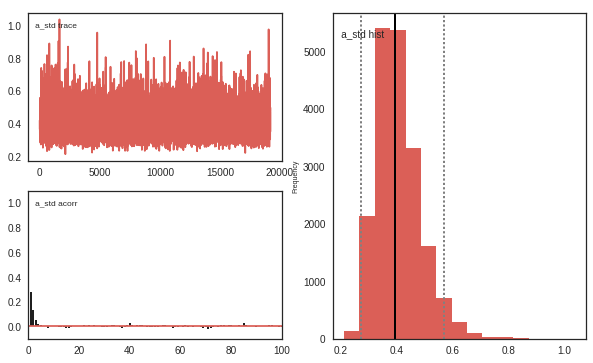

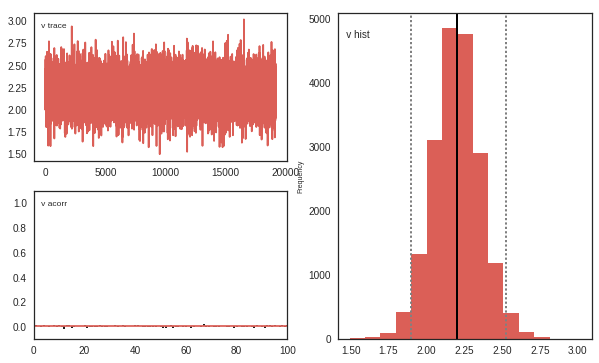

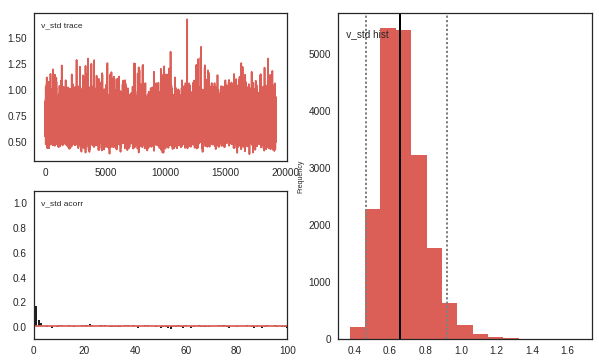

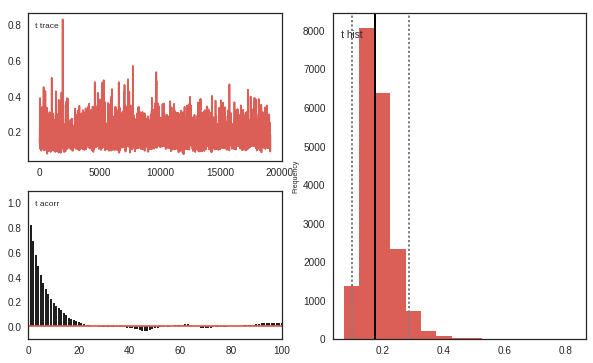

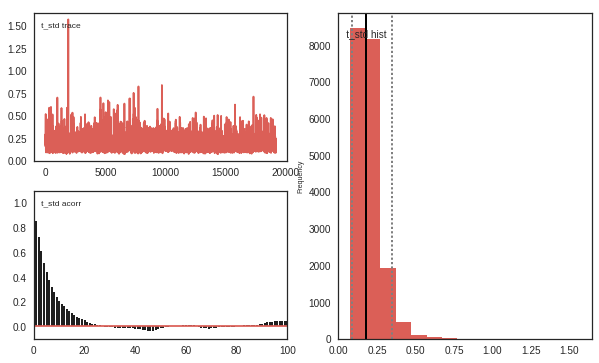

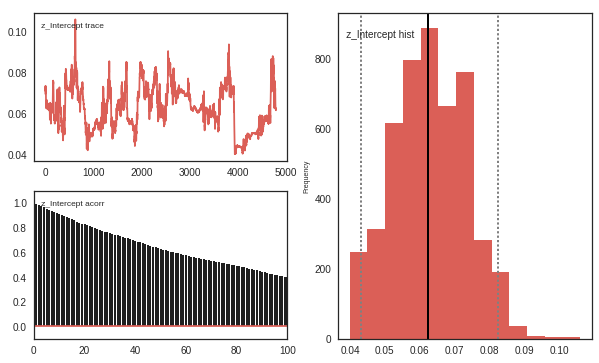

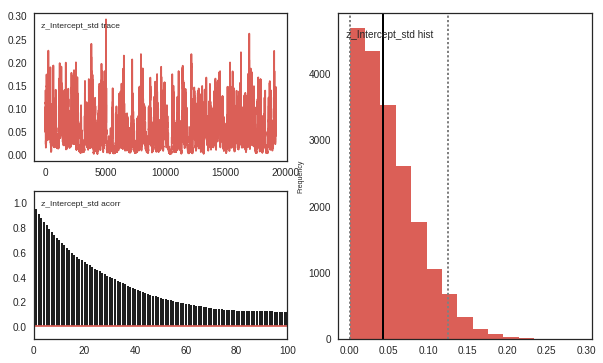

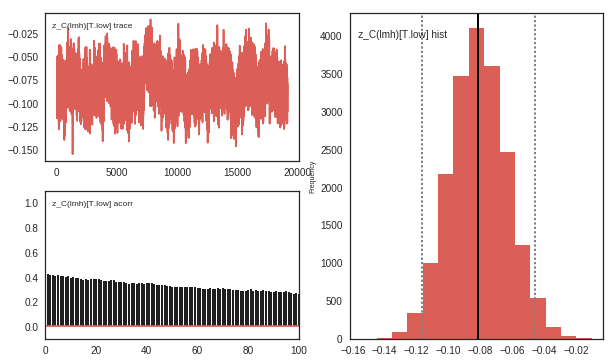

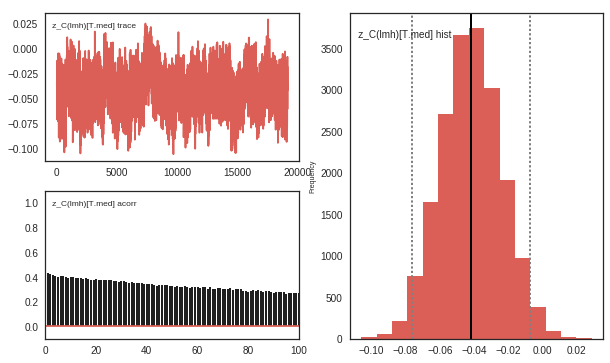

In [9]:
def run_model(id):
    import hddm
    import os.path
    import pandas as pd
    import numpy as np
    from patsy import dmatrix
    from pandas import Series
    
    #load data
    data = hddm.load_csv('/home/Projects/scenestats/exp1_scce.csv') 
    data.rename(columns = {'Unnamed: 0': 'id', 'correct':'response'}, inplace = True)
    data = data.dropna()
    
    #link func for stimulus coding
    def z_link_func(x, data=data):
        stim = (np.asarray(dmatrix('0 + C(s,[[1],[-1]])', {'s':data.stimulus.ix[x.index]})))
        return 1 / (1 + np.exp(-(x * stim)))
    
    z_reg =  {'model': "z ~ 1 + C(lmh)", 'link_func': z_link_func}

    os.chdir(u'/home/nseijde1')
    reg_descr = [z_reg]
    m = hddm.HDDMRegressor(data, reg_descr, include='z')
    m.find_starting_values()

    m.sample(5000, burn=200, dbname='mtraces_z_condition%i.db'%id, db='pickle')
    return m

# here we run the 4 chains: 
os.chdir(u'/home/nseijde1')
jobs = c[:].map(run_model, range(4)) # 4 CPUs
models = jobs.get()

# concatenate the chains to get one model
combined_model = kabuki.utils.concat_models(models)
os.chdir('/home/Projects/scenestats/z_condition')  
combined_model.save('m')
combined_model.plot_posteriors(save=True)

# compute gelman rubin to evaluate model convergence (values should be close to zero & !>1.2)
gr = hddm.analyze.gelman_rubin(models)
text_file = open('gelman_rubin.txt', 'w')
for p in gr.items():
     text_file.write("%s:%s\n" % p)
text_file.close()

In [11]:
os.chdir('/home/Projects/scenestats/z_condition')
model = hddm.load('m')
print model.dic

nan


**2. one model in which we estimate both v and z**. This way, we could measure response-bias (in favor of animal or non-animal) and drift rate for the three conditions (low, med, high) while assuming the same drift rate for both stimuli.


Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(lmh)[T.low]
Plotting v_C(lmh)[T.med]
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_C(lmh)[T.low]
Plotting z_C(lmh)[T.med]


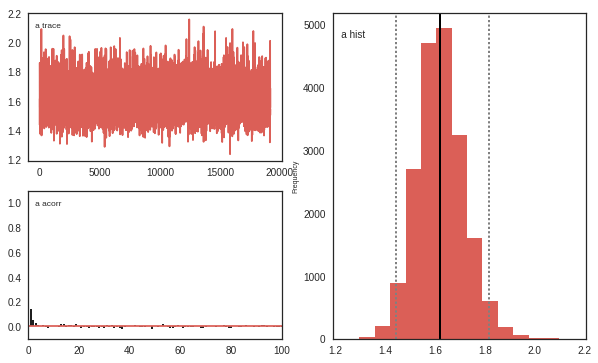

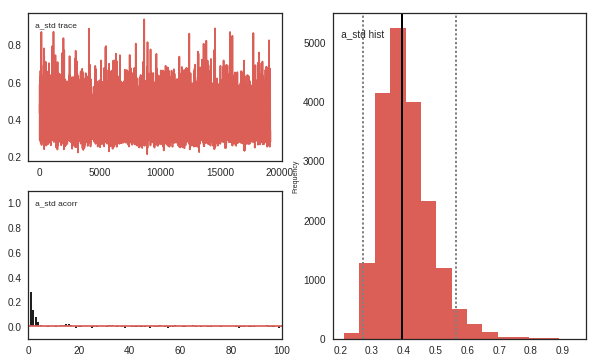

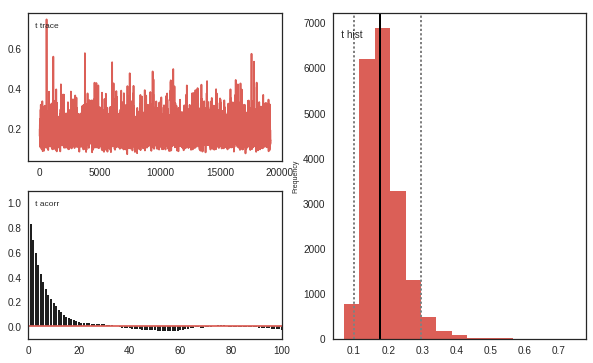

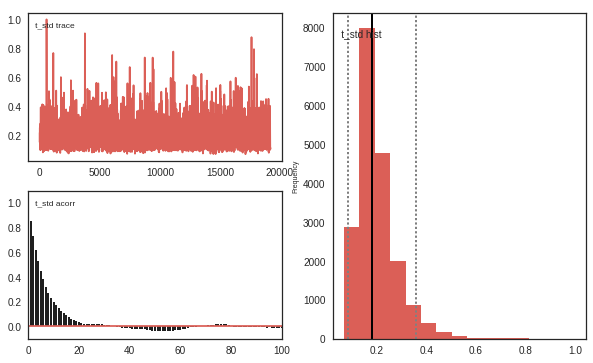

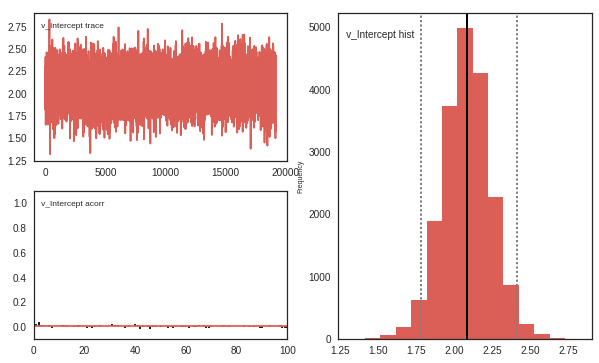

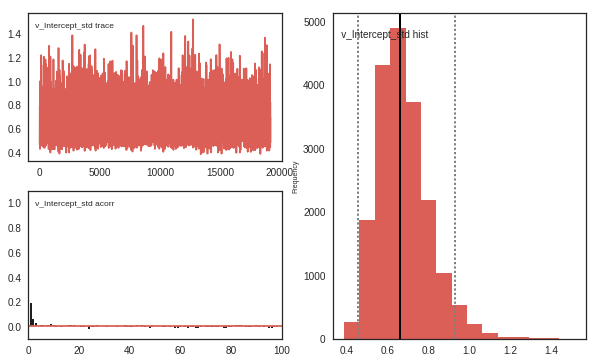

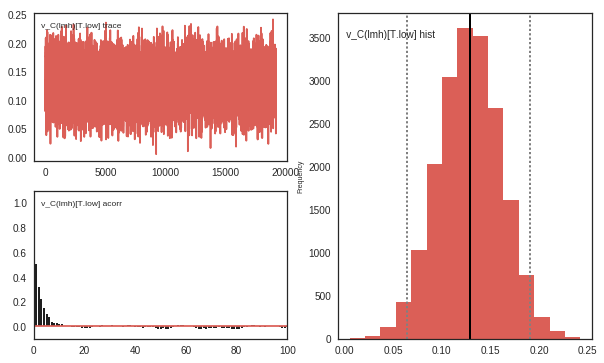

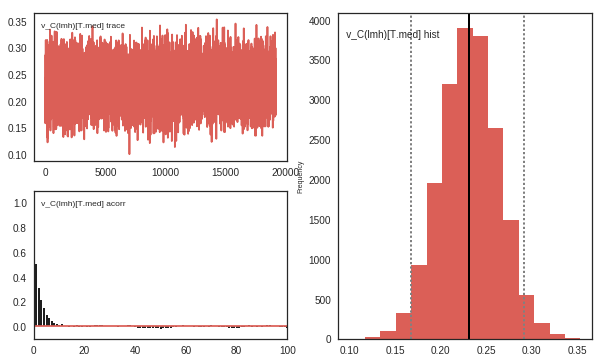

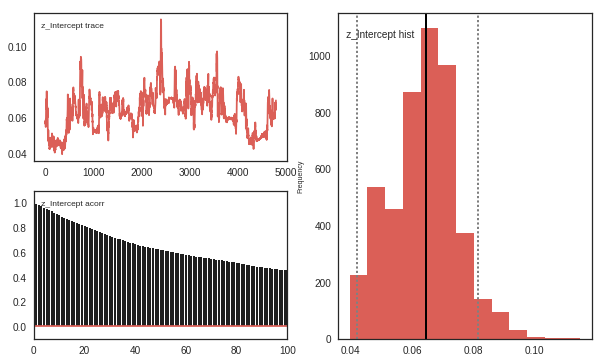

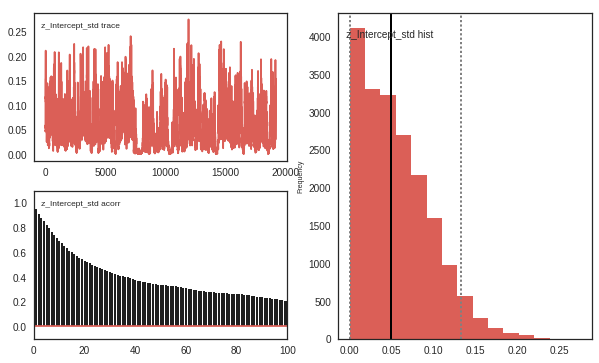

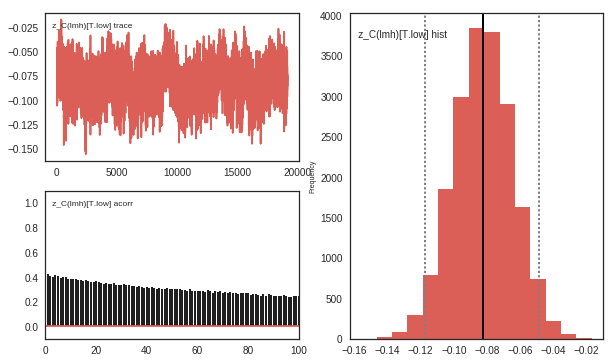

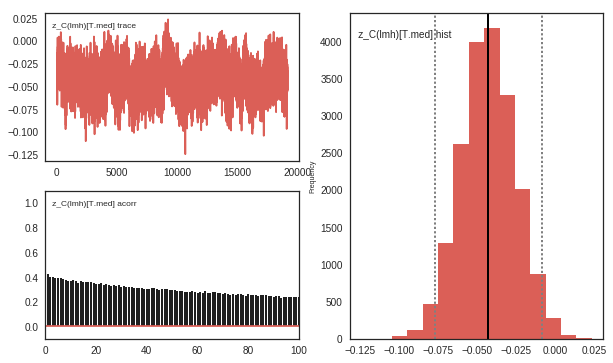

In [10]:
def run_model(id):
    import hddm
    import os.path
    import pandas as pd
    import numpy as np
    from patsy import dmatrix
    from pandas import Series
    
    #load data
    data = hddm.load_csv('/home/Projects/scenestats/exp1_scce.csv') 
    data.rename(columns = {'Unnamed: 0': 'id', 'correct':'response'}, inplace = True)
    data = data.dropna()
    
    #link func for stimulus coding
    def z_link_func(x, data=data):
        stim = (np.asarray(dmatrix('0 + C(s,[[1],[-1]])', {'s':data.stimulus.ix[x.index]})))
        return 1 / (1 + np.exp(-(x * stim)))
    
    z_reg =  {'model': "z ~ 1 + C(lmh)", 'link_func': z_link_func}
    v_reg =  {'model': "v ~ 1 + C(lmh)", 'link_func': lambda x: x}
    
    os.chdir(u'/home/nseijde1')
    reg_descr = [v_reg, z_reg]
    m = hddm.HDDMRegressor(data, reg_descr, include='z')
    m.find_starting_values()

    m.sample(5000, burn=200, dbname='mtraces_zv_condition%i.db'%id, db='pickle')
    return m

# here we run the 4 chains: 
os.chdir(u'/home/nseijde1')
jobs = c[:].map(run_model, range(4)) # 4 CPUs
models = jobs.get()

# concatenate the chains to get one model
combined_model = kabuki.utils.concat_models(models)
os.chdir('/home/Projects/scenestats/zv_condition')  
combined_model.save('m')
combined_model.plot_posteriors(save=True)

# compute gelman rubin to evaluate model convergence (values should be close to zero & !>1.2)
gr = hddm.analyze.gelman_rubin(models)
text_file = open('gelman_rubin.txt', 'w')
for p in gr.items():
     text_file.write("%s:%s\n" % p)
text_file.close()

In [12]:
os.chdir('/home/Projects/scenestats/zv_condition')
model = hddm.load('m')
print model.dic

nan


**3. one model in which we estimate *v*, *z* and *a* for every complexity condition**.


In [ ]:
def run_model(id):
    import hddm
    import os.path
    import pandas as pd
    import numpy as np
    from patsy import dmatrix
    from pandas import Series
    
    #load data
    data = hddm.load_csv('/home/Projects/scenestats/exp1_scce.csv') 
    data.rename(columns = {'Unnamed: 0': 'id', 'correct':'response'}, inplace = True)
    
    #link func for stimulus coding
    def z_link_func(x, data=data):
        stim = (np.asarray(dmatrix('0 + C(s,[[1],[-1]])', {'s':data.stimulus.ix[x.index]})))
        return 1 / (1 + np.exp(-(x * stim)))
    
    z_reg =  {'model': 'z ~ 1 + C(lmh)', 'link_func': z_link_func}
    v_reg = {'model': 'v ~ 1 + C(lmh)', 'link_func': lambda x: x}
    a_reg = {'model': 'a ~ 1 + C(lmh)', 'link_func': lambda x: x}
    
    os.chdir(u'/home/nseijde1')
    reg_descr = [z_reg, v_reg, a_reg]
    m = hddm.HDDMRegressor(data, reg_descr, include='z')
    m.find_starting_values()
    m.sample(5000, burn=200, dbname='mtraces_zva_condition%i.db'%id, db='pickle')
    return m

# here we run the 4 chains: 
os.chdir(u'/home/nseijde1')
jobs = c[:].map(run_model, range(4)) # 4 CPUs
models = jobs.get()

# concatenate the chains to get one model
combined_model = kabuki.utils.concat_models(models)
os.chdir('/home/Projects/scenestats/zva_condition')  
combined_model.save('m')
combined_model.plot_posteriors(save=True)

# compute gelman rubin to evaluate model convergence (values should be close to zero & !>1.2)
gr = hddm.analyze.gelman_rubin(models)
text_file = open('gelman_rubin.txt', 'w')
for p in gr.items():
     text_file.write("%s:%s\n" % p)
text_file.close()

Plotting t
Plotting t_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_C(lmh)[T.low]
Plotting z_C(lmh)[T.med]
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(lmh)[T.low]
Plotting v_C(lmh)[T.med]
Plotting a_Intercept
Plotting a_Intercept_std
Plotting a_C(lmh)[T.low]
Plotting a_C(lmh)[T.med]
nan


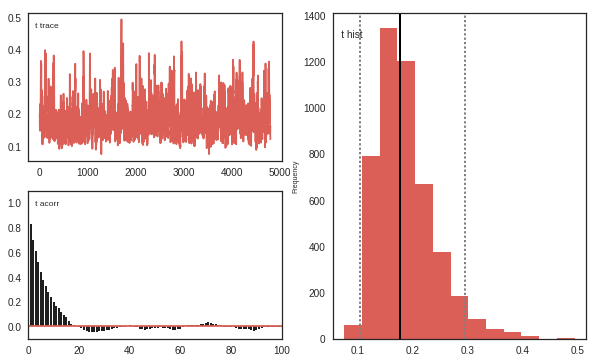

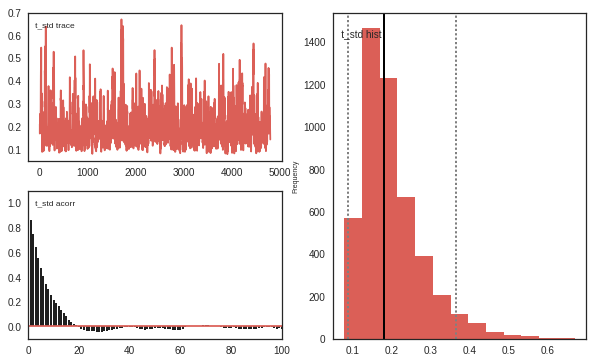

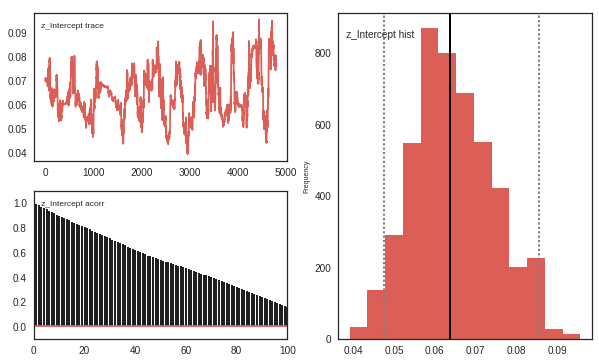

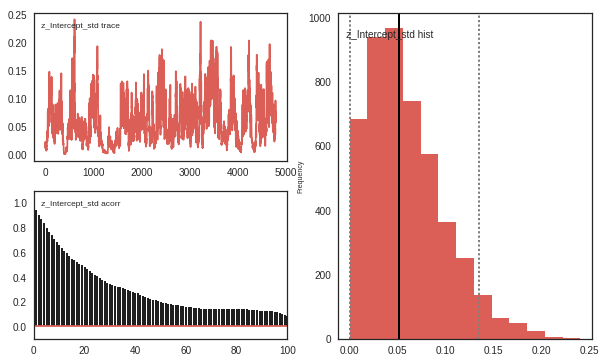

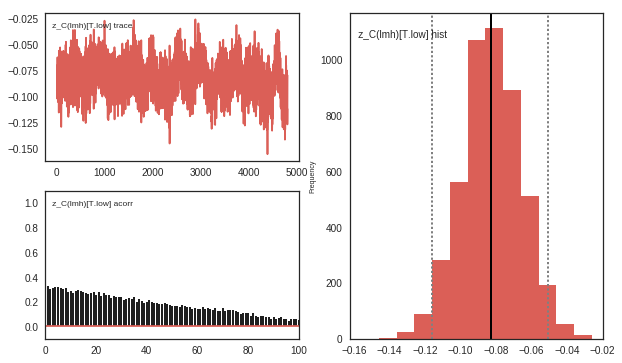

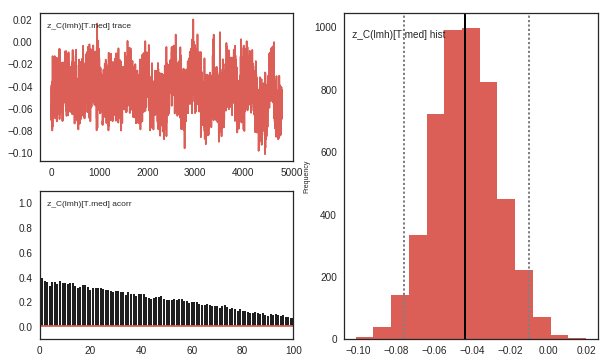

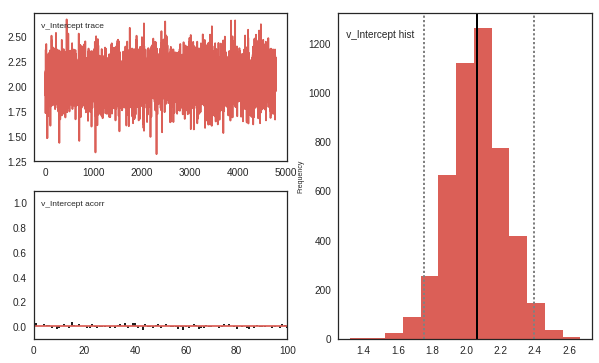

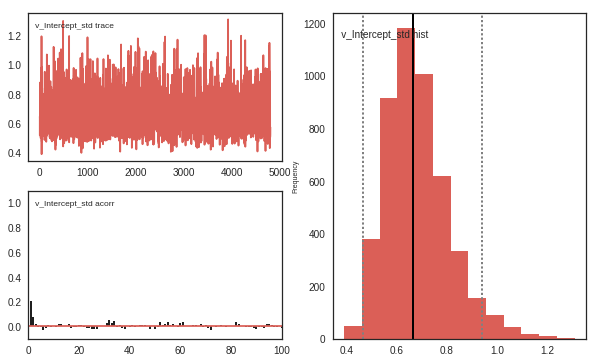

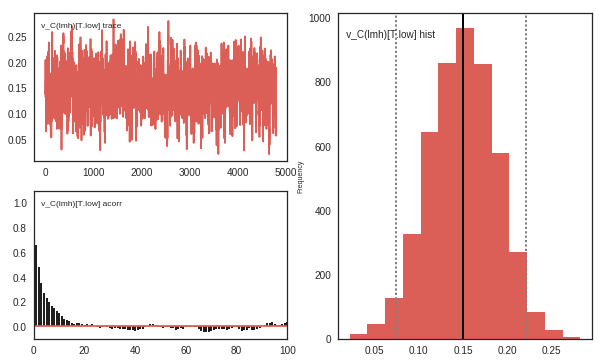

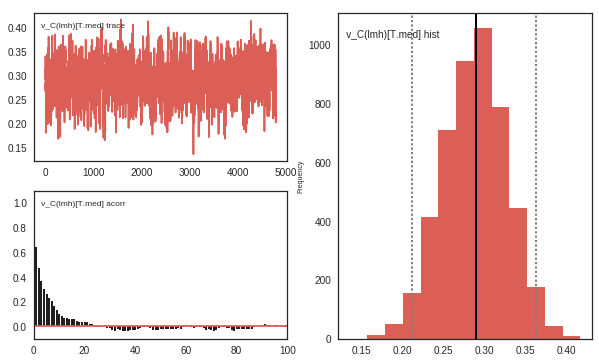

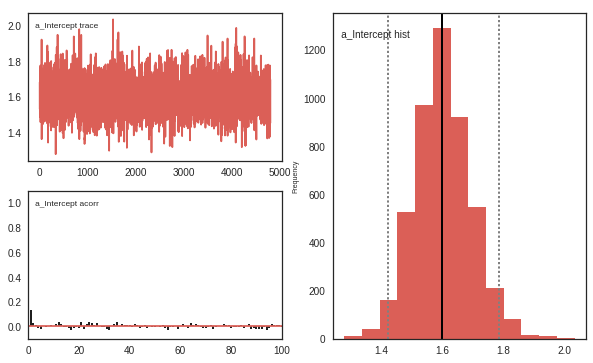

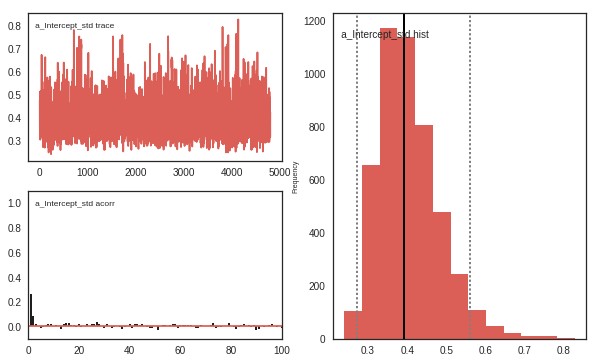

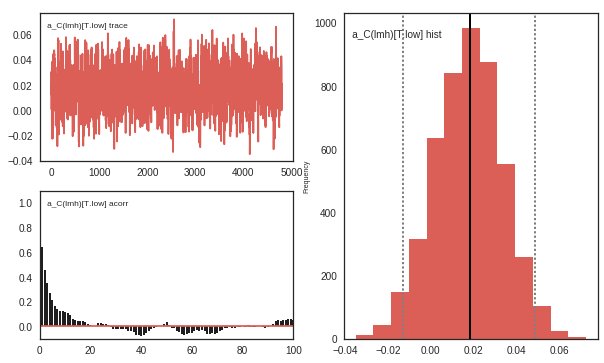

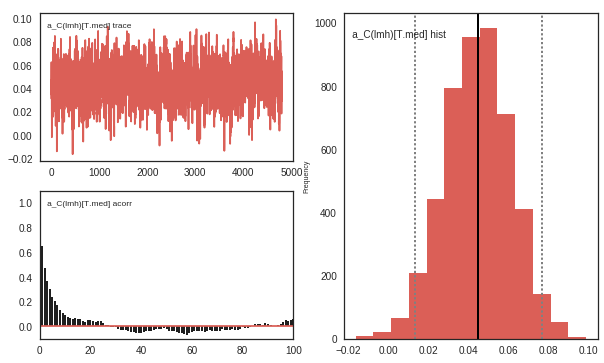

In [5]:
os.chdir('/home/Projects/scenestats/zva_condition')
model = hddm.load('m')
model.plot_posteriors()
#model.print_stats()
print model.dic

**4. one model in which we estimate *v*, *z* and *a* for every complexity condition and, using the depends_on key argument, two intercepts for *a* (speed, accurate)**

    

Plotting t
Plotting t_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_C(lmh)[T.low]
Plotting z_C(lmh)[T.med]
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(lmh)[T.low]
Plotting v_C(lmh)[T.med]
Plotting a_Intercept(Ac)
Plotting a_Intercept(Sp)
Plotting a_Intercept_std
Plotting a_C(lmh)[T.low]
Plotting a_C(lmh)[T.med]


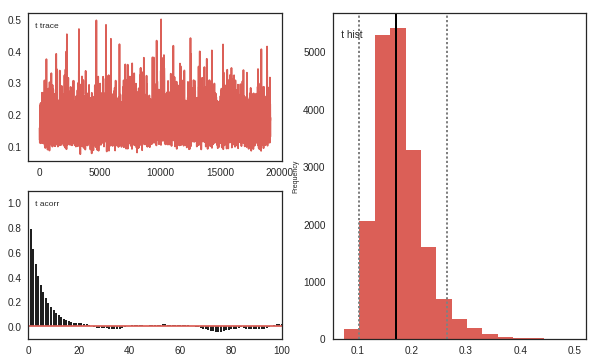

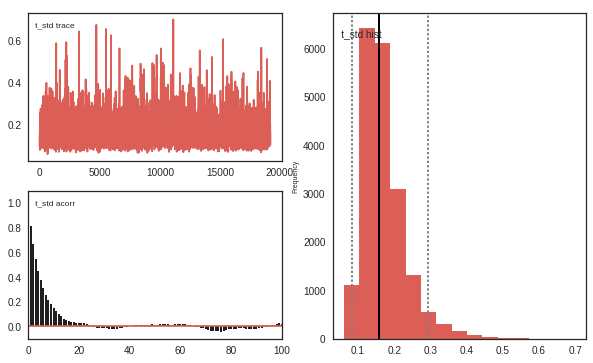

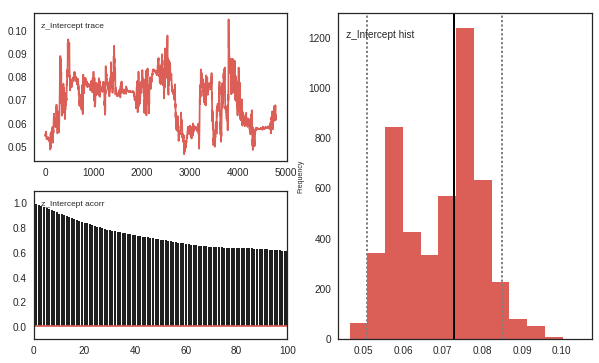

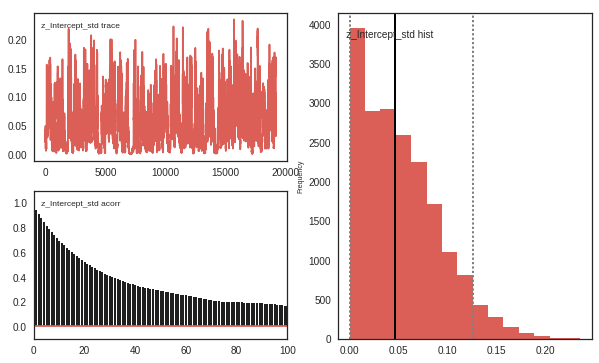

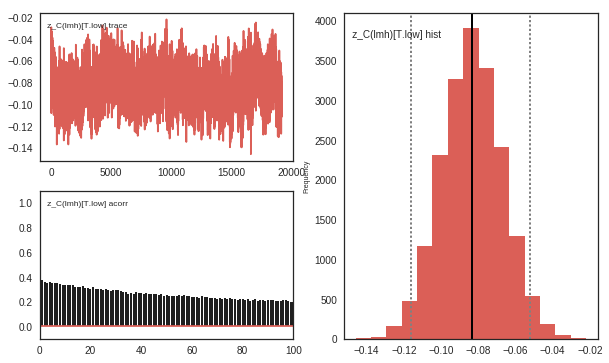

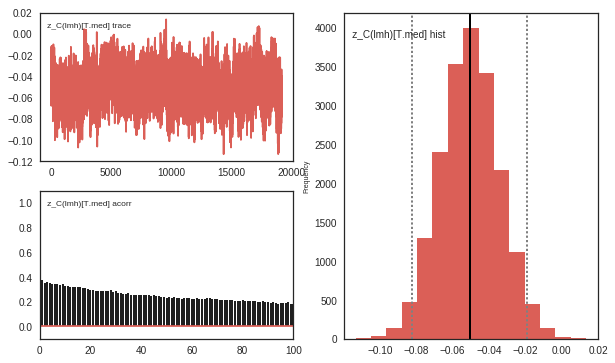

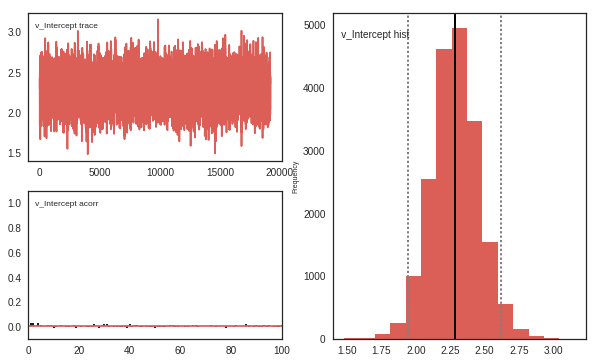

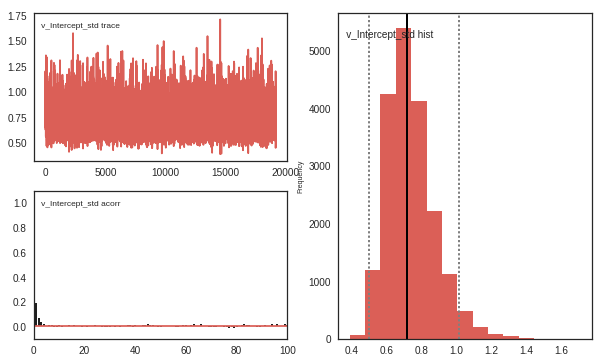

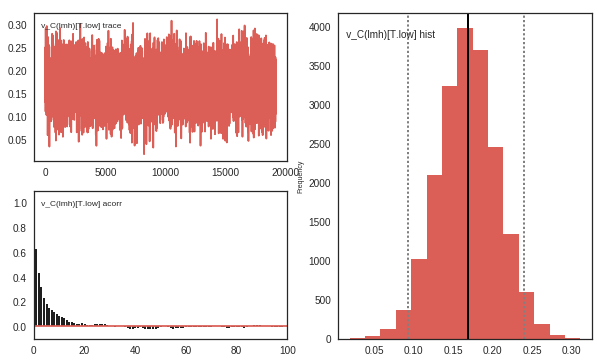

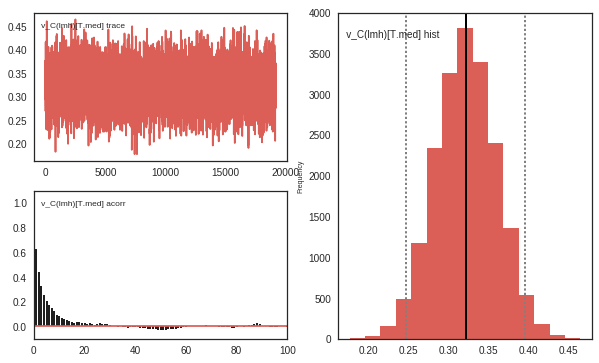

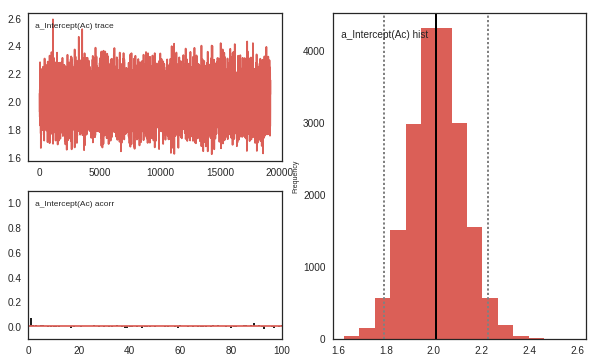

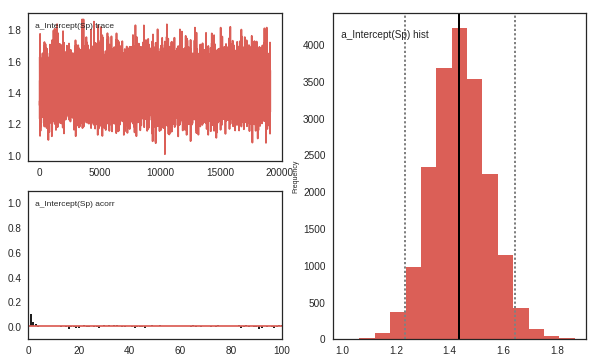

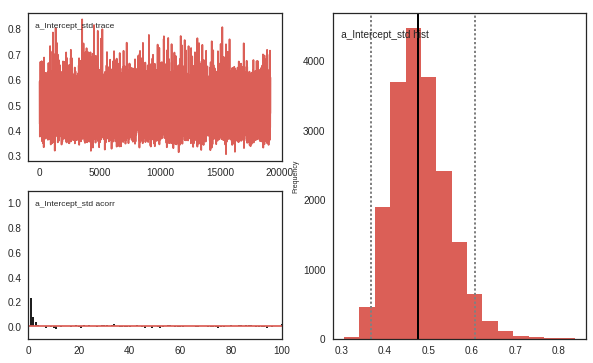

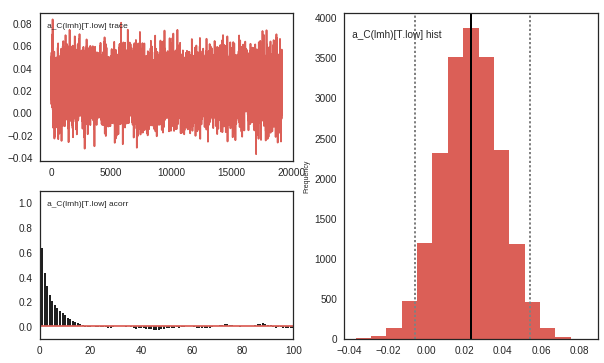

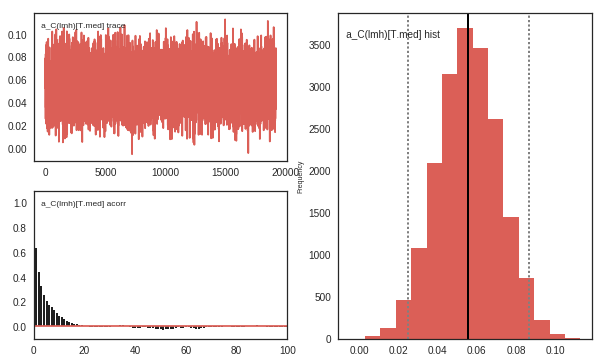

In [7]:
def run_model(id):
    import hddm
    import os.path
    import pandas as pd
    import numpy as np
    from patsy import dmatrix
    from pandas import Series
    
    #load data
    data = hddm.load_csv('/home/Projects/scenestats/exp1_scce.csv') 
    data.rename(columns = {'Unnamed: 0': 'id', 'correct':'response'}, inplace = True)
    data = data.dropna()
    
    #link func for stimulus coding
    def z_link_func(x, data=data):
        stim = (np.asarray(dmatrix('0 + C(s,[[1],[-1]])', {'s':data.stimulus.ix[x.index]})))
        return 1 / (1 + np.exp(-(x * stim)))
    
    z_reg =  {'model': 'z ~ 1 + C(lmh)', 'link_func': z_link_func}
    v_reg = {'model': 'v ~ 1 + C(lmh)', 'link_func': lambda x: x}
    a_reg = {'model': 'a ~ 1 + C(lmh)', 'link_func': lambda x: x}
    
    os.chdir(u'/home/nseijde1')
    #define and run model
    reg_descr = [z_reg, v_reg, a_reg]
    m = hddm.HDDMRegressor(data, reg_descr, depends_on={'a':'SpAc'},include='z', p_outlier=0.05)
    m.find_starting_values()
    #m.sample(20000, burn=7500, thin=10, dbname='mtraces_z_SC_%i.db'%id, db='pickle')
    m.sample(5000, burn=200, dbname='mtraces_zva_SpAc%i.db'%id, db='pickle')
    return m

os.chdir(u'/home/nseijde1')
jobs = c[:].map(run_model, range(4)) # 4 is the number of CPUs
models = jobs.get()

combined_model = kabuki.utils.concat_models(models)
os.chdir('/home/Projects/scenestats/zva_condition_SpAc')  
combined_model.save('m')
combined_model.plot_posteriors(save=True)

# compute gelman rubin
gr = hddm.analyze.gelman_rubin(models)
text_file = open('gelman_rubin.txt', 'w')
for p in gr.items():
     text_file.write("%s:%s\n" % p)
text_file.close()

In [3]:
os.chdir('/home/Projects/scenestats/zva_condition_SpAc')
model = hddm.load('m')
print model.dic

nan


#### Model did not converge; what do the estimates look like? 

In [4]:
model.print_stats('model_printstats.txt') #print stats + dic 
model.gen_stats('model_stats.txt') # point estimates only
model_group_reg_stats = model.gen_stats()

z_Intercept = model.nodes_db.node[['z_Intercept']].mean()
z_TB = model.nodes_db.node[['z_C(lmh)[T.low]']].mean()
z_TC = model.nodes_db.node[['z_C(lmh)[T.med]']].mean()
z_A = round(1/(1+np.exp(-(np.float(z_Intercept)))),3)
z_B = round(1/(1+np.exp(-(np.float(z_Intercept)+np.float(z_TB)))),3)
z_C = round(1/(1+np.exp(-(np.float(z_Intercept)+np.float(z_TC)))),3)
print "starting points estimated for low: ", z_B,"med: ", z_C," and high: ", z_A

v_Intercept = model.nodes_db.node[['v_Intercept']].mean()
v_TB = model.nodes_db.node[['v_C(lmh)[T.low]']].mean()
v_TC = model.nodes_db.node[['v_C(lmh)[T.med]']].mean()
v_A = round(v_Intercept,3)
v_B = round(v_TB,3)
v_C = round(v_TC,3)
print "drift rates points estimated for low: ", v_A+v_B,"med: ", v_A+v_C," and high: ", v_A

a_Intercept = model.nodes_db.node[['a_Intercept(Ac)']].mean()
a_TB = model.nodes_db.node[['a_C(lmh)[T.low]']].mean()
a_TC = model.nodes_db.node[['a_C(lmh)[T.med]']].mean()
a_A = round(a_Intercept,3)
a_B = round(a_TB,3)
a_C = round(a_TC,3)
print "response boundary for Accurate low: ", a_A+a_B,"med: ", a_A+a_C," and high: ", a_A

a_Intercept = model.nodes_db.node[['a_Intercept(Sp)']].mean()
a_TB = model.nodes_db.node[['a_C(lmh)[T.low]']].mean()
a_TC = model.nodes_db.node[['a_C(lmh)[T.med]']].mean()
a_A = round(a_Intercept,3)
a_B = round(a_TB,3)
a_C = round(a_TC,3)
print "response boundary for Speed low: ", a_A+a_B,"med: ", a_A+a_C," and high: ", a_A

starting points estimated for low:  0.496 med:  0.504  and high:  0.517
drift rates points estimated for low:  2.455 med:  2.609  and high:  2.286
response boundary for Accurate low:  2.037 med:  2.069  and high:  2.013
response boundary for Speed low:  1.462 med:  1.494  and high:  1.438


## Using a different condition for the intercept

In an answer to a different hddm-user with similar convergence problems, Michael J. Frank mentioned that a reason for the lack of convergence for z in HDDMRegressor could be “that the prior is biasing the estimate of z at the intercept to be 0.5. The priors for the intercept in hddmRegressor are centered around the standard priors (which are 0.5 for z). The priors for the slope terms are centered at 0. So it is recommended to mean center the values of the IV's that are used for the regressors so that any effect of the regressors would still allow for the mean value of the param in the intercept to be centered at the prior.”  (hddm-users google groups; https://groups.google.com/d/msg/hddm-users/k8dUBepPyl8/TM-SUtbZAAAJ) 
In our previous analyses, the 'high' condition was taken as the intercept. Therefore, we have run the analyses two more times with 'low' and 'medium' as the intercepts, respectively.

**5. same model as 4, now using 'medium' as the intercept for z**


In [ ]:
def run_model(id):
    import hddm
    import os.path
    import pandas as pd
    import numpy as np
    from patsy import dmatrix
    from pandas import Series
    
    #load data
    data = hddm.load_csv('/home/Projects/scenestats/exp1_scce.csv') 
    data.rename(columns = {'Unnamed: 0': 'id', 'correct':'response'}, inplace = True)
    data['lmh'] = data['lmh'].map({'low': 2, 'med': 1, 'high': 3}) #make medium condition the intercept! 
    # It may be that the prior is biasing the estimate of Z at the intercept to be 0.5. 
    # The priors for the intercept in hddmRegressor are centered around the standard priors (which are 0.5 for z). 
    # The priors for the slope terms are centered at 0.  
    # So it is recommended to mean center the values of the IV's that are used for the regressors 
    # so that any effect of the regressors would still allow for the mean value of the param in the intercept 
    # to be centered at the prior.  
    
    data = data.dropna()
    
    #link func for stimulus coding
    def z_link_func(x, data=data):
        stim = (np.asarray(dmatrix('0 + C(s,[[1],[-1]])', {'s':data.stimulus.ix[x.index]})))
        return 1 / (1 + np.exp(-(x * stim)))
    
    z_reg =  {'model': 'z ~ 1 + C(lmh)', 'link_func': z_link_func}
    v_reg = {'model': 'v ~ 1 + C(lmh)', 'link_func': lambda x: x}
    a_reg = {'model': 'a ~ 1 + C(lmh)', 'link_func': lambda x: x}
    
    os.chdir(u'/home/nseijde1')
    #define and run model
    reg_descr = [z_reg, v_reg, a_reg]
    m = hddm.HDDMRegressor(data, reg_descr, depends_on={'a':'SpAc'},include='z', p_outlier=0.05)
    m.find_starting_values()
    #m.sample(20000, burn=7500, thin=10, dbname='mtraces_z_SC_%i.db'%id, db='pickle')
    m.sample(5000, burn=200, dbname='mtraces_zva_SpAc%i.db'%id, db='pickle')
    return m

os.chdir(u'/home/nseijde1')
jobs = c[:].map(run_model, range(4)) # 4 is the number of CPUs
models = jobs.get()

combined_model = kabuki.utils.concat_models(models)
os.chdir('/home/Projects/scenestats/zva_condition_SpAc_medium')  
combined_model.save('m')
combined_model.plot_posteriors(save=True)

# compute gelman rubin
gr = hddm.analyze.gelman_rubin(models)
text_file = open('gelman_rubin.txt', 'w')
for p in gr.items():
     text_file.write("%s:%s\n" % p)
text_file.close()

In [3]:
os.chdir('/home/Projects/scenestats/zva_condition_SpAc_medium')
model = hddm.load('m')
print model.dic

nan


### Using HDDMRegressor to estimate z often leads to convergence problems
Therefore, in the next section we will use HDDMStimcoding to evaluate potential effects on z there
(based on code from Angelos Krypotos and Thomas Wiecki: https://osf.io/9fwhm/,)


** 6. one model using HDDMStimCoding, in which we estimate *v*, *z* for every complexity condition, and *a* for every complexity condition + speed/accuracy instruction**


In [ ]:
def run_model(id):
    import hddm
    import os.path
    import pandas as pd
    import numpy as np
    from patsy import dmatrix
    from pandas import Series
    
    #load data
    data = hddm.load_csv('/home/Projects/scenestats/exp1_scce.csv')  
    data.rename(columns = {'Unnamed: 0': 'id', 'resp':'response'}, inplace = True)

    data['stim'] = data['stimulus'].map({1: 1, 2: 0})
    #data['response'] = data['response'].map({1: 1, 0: 0})
    print(data.head(10))
        
    m = hddm.HDDMStimCoding(data, include='z', stim_col='stim', 
                            depends_on = {'v':'lmh', 'a':['lmh', 'SpAc'], 'z':'lmh'}, 
                            split_param='v', p_outlier=0.05)
    
    m.find_starting_values()
    #m.sample(20000, burn=7500, thin=10, dbname='mtraces_z_SC_%i.db'%id, db='pickle')
    m.sample(5000, burn=200, dbname='mtraces_zva_stimcoding%i.db'%id, db='pickle')
    return m

os.chdir(u'/home/nseijde1')
jobs = c[:].map(run_model, range(4)) # 4 is the number of CPUs
models = jobs.get()

combined_model = kabuki.utils.concat_models(models)
os.chdir('/home/Projects/scenestats/zva_stimcoding')  
combined_model.save('m')
combined_model.plot_posteriors(save=True)

# compute gelman rubin
gr = hddm.analyze.gelman_rubin(models)
text_file = open('gelman_rubin.txt', 'w')
for p in gr.items():
     text_file.write("%s:%s\n" % p)
text_file.close()

In [13]:
os.chdir(u'/home/Projects/scenestats/zva_stimcoding')
model = hddm.load('m')
print model.dic

-20864.5282614


P(z_low > z_med) =  0.256875
P(z_low > z_high) =  0.142916666667
P(z_med > z_high) =  0.320208333333
P(v_low > v_med) =  0.162708333333
P(v_low > v_high) =  0.843958333333
P(v_med > v_high) =  0.98


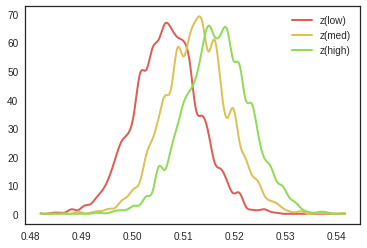

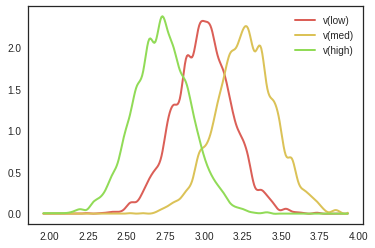

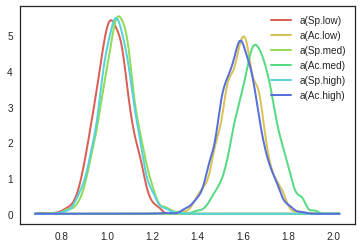

In [20]:
#starting point 
z_low, z_med, z_high = model.nodes_db.node[['z(low)', 'z(med)', 'z(high)']]
hddm.analyze.plot_posterior_nodes([z_low, z_med, z_high])

print "P(z_low > z_med) = ", (z_low.trace() > z_med.trace()).mean()
print "P(z_low > z_high) = ", (z_low.trace() > z_high.trace()).mean()
print "P(z_med > z_high) = ", (z_med.trace() > z_high.trace()).mean()

#drift
v_low, v_med, v_high = model.nodes_db.node[['v(low)', 'v(med)', 'v(high)']]
hddm.analyze.plot_posterior_nodes([v_low, v_med, v_high])

print "P(v_low > v_med) = ", (v_low.trace() > v_med.trace()).mean()
print "P(v_low > v_high) = ", (v_low.trace() > v_high.trace()).mean()
print "P(v_med > v_high) = ", (v_med.trace() > v_high.trace()).mean()

#boundary
a_Sp_low, a_Ac_low,a_Sp_med, a_Ac_med,a_Sp_high, a_Ac_high = model.nodes_db.node[['a(Sp.low)', 'a(Ac.low)','a(Sp.med)', 'a(Ac.med)','a(Sp.high)', 'a(Ac.high)']]
hddm.analyze.plot_posterior_nodes([a_Sp_low, a_Ac_low,a_Sp_med, a_Ac_med,a_Sp_high, a_Ac_high])


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


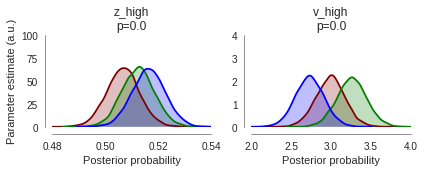

In [19]:
fig_dir = u'/home/Projects/scenestats/zva_stimcoding'
params_of_interest = ['z(low)', 'z(med)', 'z(high)','v(low)', 'v(med)', 'v(high)']
titles = ['z_low', 'z_med','z_high','v_low', 'v_med','v_high' ]

traces = []
for p in range(len(params_of_interest)):
    traces.append(model.nodes_db.node[params_of_interest[p]].trace.gettrace())

stats = []
for p in range(len(params_of_interest)):
    stat = min(np.mean(traces[p] > 0), np.mean(traces[p] < 0))
    stats.append(min(stat, 1-stat))
#stats = np.array(stats)    

print stats
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(len(params_of_interest),2.5))

ax_nr = 0
pl = 0
cc=['maroon','green','blue','maroon','green','blue']
for p in range(len(params_of_interest)):
    data = [traces[p]]
    ax = axes[ax_nr]
    for d, label, c in zip(data, ['1',], ['black']):
        sns.kdeplot(d, vertical=False, shade=True, color=cc[pl], ax=ax)
        ax.set_xlabel('Posterior probability')
        ax.set_title('{}\np={}'.format(titles[pl], round(stats[p],3)))
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.5)
            ax.tick_params(width=0.5)          
        pl+=1
        if pl == 3:
            ax_nr+=1
        
sns.despine(offset=7, trim=False)
axes[0].set_ylabel('Parameter estimate (a.u.)')
axes[0].axvline(x=0, color='r', linestyle='--')
axes[1].axvline(x=0, color='r', linestyle='--')
axes[0].set_ylim(0,100)
axes[0].set_xlim(0.48,0.54)
axes[1].set_ylim(0,4)
axes[1].set_xlim(2,4)

plt.tight_layout()
fig.savefig(os.path.join(fig_dir, 'posteriors.pdf'))